In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Package

In [2]:
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import transforms
from torch.utils import data
import copy
import random
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print(device)

cuda


# Load data

In [4]:
train_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
#data preprocessing - train
train_image = []
train_label = []
class_list = ["WithMask", "WithoutMask"]  #class = [1, 0]
for i in class_list:
    basepath = os.path.join("/content/drive/MyDrive/深度學習實作與應用/Final Project/Dataset/Train/", i, "*.png")
    cand_fn = glob.glob(basepath)
    for afn in cand_fn:
        img = Image.open(afn)
        input_image = Image.open(afn)
        input_tensor = train_preprocess(input_image)
        train_image.append(input_tensor)
        if i == "WithMask":
            train_label.append(1)
        else:
            train_label.append(0)

In [6]:
#data preprocessing - valid
valid_image = []
valid_label = []
class_list = ["WithMask", "WithoutMask"]  #class = [1, 0]
for i in class_list:
    basepath = os.path.join("/content/drive/MyDrive/深度學習實作與應用/Final Project/Dataset/Validation/", i, "*.png")
    cand_fn = glob.glob(basepath)
    for afn in cand_fn:
        img = Image.open(afn)
        input_image = Image.open(afn)
        input_tensor = train_preprocess(input_image)
        valid_image.append(input_tensor)
        if i == "WithMask":
            valid_label.append(1)
        else:
            valid_label.append(0)

In [5]:
#data preprocessing - test
test_image = []
test_label = []
test_filename = []
class_list = ["WithMask", "WithoutMask"]  #class = [1, 0]
for i in class_list:
    basepath = os.path.join("/content/drive/MyDrive/深度學習實作與應用/Final Project/Dataset/Test/", i, "*.png")
    cand_fn = glob.glob(basepath)
    for afn in cand_fn:
        test_filename.append(afn)
        img = Image.open(afn)
        input_image = Image.open(afn)
        input_tensor = test_preprocess(input_image)
        test_image.append(input_tensor)
        if i == "WithMask":
            test_label.append(1)
        else:
            test_label.append(0)

In [ ]:
#shuffle
def myfunction():
  return 0.1

random.shuffle(train_image, myfunction)
random.shuffle(train_label, myfunction)
random.shuffle(valid_image, myfunction)
random.shuffle(valid_label, myfunction)
random.shuffle(test_image, myfunction)
random.shuffle(test_label, myfunction)

# Build model

In [6]:
#characterize a dataset
class Dataset(data.Dataset):
  def __init__(self, Xnp, Ynp):
    self.labels = Ynp
    self.nobs = len(Xnp)
    self.Xnp = Xnp
    self.Ynp = Ynp

  def __len__(self):
    return self.nobs
  
  def __getitem__(self, index):
    X = self.Xnp[index]
    y = self.Ynp[index]
    return X, y

In [7]:
test_set = Dataset(test_image, test_label)
test_loader = data.DataLoader(test_set, batch_size=len(test_label), shuffle=True, num_workers=0)
x_test, y_test = next(iter(test_loader))
x_test = x_test.to('cuda')
y_test = y_test.type(torch.LongTensor).to('cuda')

In [9]:
train_set = Dataset(train_image, train_label)
valid_set = Dataset(valid_image, valid_label)
test_set = Dataset(test_image, test_label)

In [10]:
train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
valid_loader = data.DataLoader(valid_set, batch_size=len(valid_label), shuffle=True, num_workers=0)
test_loader = data.DataLoader(test_set, batch_size=len(test_label), shuffle=True, num_workers=0)

In [11]:
x_valid, y_valid = next(iter(valid_loader))
x_test, y_test = next(iter(test_loader))

In [12]:
x_valid = x_valid.to('cuda')
y_valid = y_valid.type(torch.LongTensor).to('cuda')
x_test = x_test.to('cuda')
y_test = y_test.type(torch.LongTensor).to('cuda')

In [13]:
X_batch, y_batch = next(iter(test_loader))
print("X_batch size: ", X_batch.size())
print("y_batch size: ", y_batch.size())

X_batch size:  torch.Size([1992, 3, 224, 224])
y_batch size:  torch.Size([1992])


# Fit dataset

In [14]:
loss_fn = torch.nn.CrossEntropyLoss()

In [15]:
#fine-tune the whole model
nepoch = 50
log_interval = 10
vloss_set = []
step_set = []
minloss_set = []
LR = [0.001, 0.1]
WD = [0, 0.3]

for l in LR:
  print("Learning rate: ", l)
  for wd in WD:
    print("Weight decay: ", wd)
    min_vloss = 10**10
    step_count = 0
    tmp_vloss_set = []
    tmp_step_set = []
    net = torchvision.models.resnet18(pretrained=False)
    net.fc = nn.Linear(512, 2)
    net = net.to(device)
    best_state = copy.deepcopy(net.state_dict())
    optimizer = torch.optim.SGD(net.parameters(), lr=l, momentum=0, weight_decay=wd)

    for epoch_id in range(0, nepoch):
      step_count += 1
      if step_count >= 20:
        break
      for batch_idx, (inputs, targets) in enumerate(train_loader):
        net.train()
        inputs, targets = inputs.to(device), targets.type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        if step_count % log_interval == 0:
          valid_loss = 0.0
          valid_cnt = 0
          with torch.no_grad():
            net.eval()
            valid_outputs = net(x_valid)
            valid_loss = loss_fn(valid_outputs, y_valid)
            tmp_vloss_set.append(valid_loss.cpu())
            tmp_step_set.append(step_count)
            print(valid_loss)
            if valid_loss < min_vloss:
              min_vloss = valid_loss
              best_state = copy.deepcopy(net.state_dict())

    print("===================================================================")
    minloss_set.append(min_vloss)
    vloss_set.append(tmp_vloss_set)
    step_set.append(tmp_step_set)
    net.load_state_dict(best_state)
    torch.save(net, "/content/drive/MyDrive/深度學習實作與應用/Final Project/lr%f_wd%f"%(l, wd))
    torch.cuda.empty_cache()

Learning rate:  0.001
Weight decay:  0


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tensor(0.3006, device='cuda:0')
tensor(0.3015, device='cuda:0')
tensor(0.3010, device='cuda:0')
tensor(0.2993, device='cuda:0')
tensor(0.3018, device='cuda:0')
tensor(0.2954, device='cuda:0')
tensor(0.3015, device='cuda:0')
tensor(0.3045, device='cuda:0')
tensor(0.3011, device='cuda:0')
tensor(0.2995, device='cuda:0')
tensor(0.2988, device='cuda:0')
tensor(0.3041, device='cuda:0')
tensor(0.3019, device='cuda:0')
tensor(0.2988, device='cuda:0')
tensor(0.2974, device='cuda:0')
tensor(0.2984, device='cuda:0')
tensor(0.2977, device='cuda:0')
tensor(0.2979, device='cuda:0')
tensor(0.2988, device='cuda:0')
tensor(0.3025, device='cuda:0')
tensor(0.2984, device='cuda:0')
tensor(0.3001, device='cuda:0')
tensor(0.2999, device='cuda:0')
tensor(0.2995, device='cuda:0')
tensor(0.2995, device='cuda:0')
tensor(0.3055, device='cuda:0')
tensor(0.3045, device='cuda:0')
tensor(0.3025, device='cuda:0')
tensor(0.2974, device='cuda:0')
tensor(0.3000, device='cuda:0')
tensor(0.2976, device='cuda:0')
tensor(0

In [ ]:
#only fine-tune last layer
nepoch = 50
log_interval = 10
vloss_set = []
step_set = []
minloss_set = []
LR = [0.001, 0.1]
WD = [0, 0.3]

for l in LR:
  print("Learning rate: ", l)
  for wd in WD:
    print("Weight decay: ", wd)
    min_vloss = 10**10
    step_count = 0
    tmp_vloss_set = []
    tmp_step_set = []
    net = torchvision.models.resnet18(pretrained=True)
    for param in net.parameters():
      param.requires_grad = False
    net.fc = nn.Linear(512, 2)
    net = net.to(device)
    best_state = copy.deepcopy(net.state_dict())
    optimizer = torch.optim.SGD(net.parameters(), lr=l, momentum=0, weight_decay=wd)

    for epoch_id in range(0, nepoch):
      step_count += 1
      if step_count >= 20:
        break
      for batch_idx, (inputs, targets) in enumerate(train_loader):
        net.train()
        inputs, targets = inputs.to(device), targets.type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        if step_count % log_interval == 0:
          valid_loss = 0.0
          valid_cnt = 0
          with torch.no_grad():
            net.eval()
            valid_outputs = net(x_valid)
            valid_loss = loss_fn(valid_outputs, y_valid)
            tmp_vloss_set.append(valid_loss.cpu())
            tmp_step_set.append(step_count)
            print(valid_loss)
            if valid_loss < min_vloss:
              min_vloss = valid_loss
              best_state = copy.deepcopy(net.state_dict())

    print("===================================================================")
    minloss_set.append(min_vloss)
    vloss_set.append(tmp_vloss_set)
    step_set.append(tmp_step_set)
    net.load_state_dict(best_state)
    torch.save(net, "/content/drive/MyDrive/深度學習實作與應用/Final Project/lr%f_wd%f"%(l, wd))
    torch.cuda.empty_cache()

Learning rate:  0.001
Weight decay:  0


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

tensor(0.3096, device='cuda:0')
tensor(0.3109, device='cuda:0')
tensor(0.3070, device='cuda:0')
tensor(0.3045, device='cuda:0')
tensor(0.3048, device='cuda:0')
tensor(0.3025, device='cuda:0')
tensor(0.3049, device='cuda:0')
tensor(0.3056, device='cuda:0')
tensor(0.3032, device='cuda:0')
tensor(0.3059, device='cuda:0')
tensor(0.3036, device='cuda:0')
tensor(0.3032, device='cuda:0')
tensor(0.3035, device='cuda:0')
tensor(0.3016, device='cuda:0')
tensor(0.3016, device='cuda:0')
tensor(0.3020, device='cuda:0')
tensor(0.3009, device='cuda:0')
tensor(0.2999, device='cuda:0')
tensor(0.3013, device='cuda:0')
tensor(0.3002, device='cuda:0')
tensor(0.2989, device='cuda:0')
tensor(0.2995, device='cuda:0')
tensor(0.2975, device='cuda:0')
tensor(0.2961, device='cuda:0')
tensor(0.2938, device='cuda:0')
tensor(0.2939, device='cuda:0')
tensor(0.2947, device='cuda:0')
tensor(0.2952, device='cuda:0')
tensor(0.2943, device='cuda:0')
tensor(0.2937, device='cuda:0')
tensor(0.2922, device='cuda:0')
tensor(0

In [16]:
print(minloss_set)
print(min(minloss_set))
print(minloss_set.index(min(minloss_set)))

[tensor(0.2954, device='cuda:0'), tensor(0.3135, device='cuda:0'), tensor(0.1859, device='cuda:0'), tensor(0.5579, device='cuda:0')]
tensor(0.1859, device='cuda:0')
2


In [8]:
with torch.no_grad():
  best_net = torch.load('/content/drive/MyDrive/深度學習實作與應用/Final Project/lr0.001000_wd0.000000')
  best_net.eval()
  prediction = best_net(x_test)

In [9]:
pred_class = torch.argmax(prediction, dim=1).cpu()
y_test_cpu = y_test.cpu()
for i in range(2):
  ind = (pred_class == i)
  current_class = pred_class[ind]
  y_i = y_test_cpu[ind]
  print(class_list[i], " = ", accuracy_score(y_i, current_class))
print("Test accuracy: ", accuracy_score(y_test_cpu, pred_class))

WithMask  =  0.8709386281588448
WithoutMask  =  0.9502262443438914
Test accuracy:  0.9061244979919679


In [ ]:
#fine-tune last layer
for i in range(len(pred_class)):
  if pred_class[i] != y_test_cpu[i]:
    img = Image.open(test_filename[i])
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
with torch.no_grad():
  best_net = torch.load('/content/drive/MyDrive/深度學習實作與應用/Final Project/model_fine-tune all/lr0.100000_wd0.000000')
  best_net.eval()
  prediction = best_net(x_test)

In [ ]:
pred_class = torch.argmax(prediction, dim=1).cpu()
y_test_cpu = y_test.cpu()
for i in range(2):
  ind = (pred_class == i)
  current_class = pred_class[ind]
  y_i = y_test_cpu[ind]
  print(class_list[i], " = ", accuracy_score(y_i, current_class))
print("Test accuracy: ", accuracy_score(y_test_cpu, pred_class))

WithMask  =  0.9842364532019704
WithoutMask  =  0.9897645854657113
Test accuracy:  0.9869477911646586


In [ ]:
#fine-tune all
for i in range(len(pred_class)):
  if pred_class[i] != y_test_cpu[i]:
    img = Image.open(test_filename[i])
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [10]:
print('Precision:', metrics.precision_score(y_test_cpu, pred_class))
print('Recall:', metrics.recall_score(y_test_cpu, pred_class))
print('F1:', metrics.f1_score(y_test_cpu, pred_class))

Precision: 0.9502262443438914
Recall: 0.854526958290946
F1: 0.8998393144081414


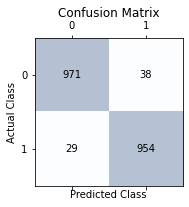

In [ ]:
confmat = confusion_matrix(y_true=y_test_cpu, y_pred=pred_class)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0, 1])
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix", y=1.1)
plt.tight_layout()
plt.show
plt.savefig('confu_matrix.png')

## fine-tune all <br>
best model: lr0.100000_wd0.000000 <br>
accuracy: <br>
WithMask  =  0.9842364532019704, 
WithoutMask  =  0.9897645854657113, 
Test accuracy:  0.9869477911646586 <br>
Precision: 0.9897645854657113 <br>
Recall: 0.9837232960325534 <br>
F1: 0.986734693877551 <br>

## fine-tune last layer <br>
best model: lr0.100000_wd0.300000 <br>
accuracy: <br>
WithMask  =  0.971, 
WithoutMask  =  0.9616935483870968, 
Test accuracy:  0.9663654618473896 <br>
Precision: 0.9616935483870968 <br>
Recall: 0.970498474059003 <br>
F1: 0.9660759493670885 <br>